# The task
Musical instrument identification is polyphonic music is a problem in the context of music information retrieval, that may aid in the development of advanced music related AI applications. If we consider the number of musical instruments that we may be interested of classifying, the variety of types of instrument playing, the chromatic range of each instrument, the variety of music genres and the polyphonic nature of music, we can understand the difficulty of such a challenge. 
In this project, we will classify eleven musical instruments as being dominant or not in small segments of music.

# The dataset
For this purpose we will make use of the IRMAS dataset[1]. IRMAS contains 3 second long segments of music annotated with a single label, that of the predominant instrument. Rhythm instruments like bass and drums are most likely present but not labelled. In total, annotations for 11 different classes are provided. Namely, the classes are: 
1. cello
2. clarinet
3. flute
4. acoustic guitar
5. electric guitar
6. organ
7. piano
8. saxophone
9. trumpet
10. violin
11. human voice  


As we can see, some classes are not easily separated even by an untrained human ear. For instance, organ may sound like a piano. On the other hand, some of these instruments share a very large chromatic range, like violin, piano and organ.

The dataset also provides multilabel pieces of music, but for this project we will only consider the single label case.

# EDA, preprocessing and feature extraction

Our data are separated in 11 files, one for each class. As a preprocessing step we choose to further slice each segment at two, decreasing each segment's resolution to 1.5 seconds. Our goal is to double the size of the dataset while using an informative and short signal length. 

Below we will demonstrate the performance of two CNN models, a custom CNN and a pretrained VGG model. For each of these two models, we extract the Mel-scaled spectrograms of the audio files using different parameters and the Librosa library. More precisely,


1. For the custom CNN: 

* Preprocessing:
   * Load the audio files in stereo format(2D time series).
   * Downsample to 22.050 Hz. This step helps fight dimensionality while not losing significant information since 22,05 KHz is already a high sampling rate for our problem.
   * Further slice segments in half to obtain 1.5 second resolution. In this way,we double the size of the dataset using original(not artificial) data while keeping an informative signal length.
   * Extract Mel-scaled spectrograms, one for each dimension of the stereo signal using 1024 length for the FFT window, 128 frames for the hop length and the window size defaults to the FFT length.
   * Finally, the 2X124X166 Mel-scaled spectrograms are min-max normalized before fed to the model.

* Data augmentation:
 * Frequency/time masking: The masking selects a starting point from the frequency axis of the 
spectrogram and masks the whole frequency in the range of [f<sub>0</sub>, f<sub>0</sub>+F), where f<sub>0</sub> is the starting point in the axis of the Mel frequencies and ranges in (0, #channels - F). #channels denotes the total number of the Mel frequencies in the spectrogram. Below a masking sample is presented:

![[cel][cla]0119__1_masked_ch2.png](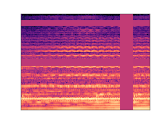)

The same procedure goes for time masking, but masking the whole time group.


* Model hyperparameters:
  * Adam optimizer.
  * Cross Entropy loss function.
  * Learning rate of 1e-4 coupled with the ReduceLROnPlateau() scheduler which reduces learning rate by a factor of 0.1 if the validation loss does not decrease for 5 epochs.
  * Batch size of 32.
  * Early stopping to halt an overfitting model's training in time(7 epochs).
  * The architecture of the model is comprised of 4 consecutive convolution-batch normalization-ReLU-Max pooling combinations converting the 2x124x166 input to a 64x6x9 tensor, a flatten layer, 2 fully connected-ReLU-Max pooling combinations leading to a 250 1D tensor, and a final fully connected layer with 11 output nodes, one for each class. The prediction of the model is considered the output node with the maximum value.


2. For the pretrained model:

* Preprocessing:
 * Load the audio files converting them to mono.
 * Downsample to 22.050 Hz.
 * Slice data to 1.5 second resolution.
 * Extract Mel-scaled spectrograms using 1024 length for the FFT window, 259 hop_length and 1024 for the sample window length.
 * Finally, we divide the 128x128 obtained representation with its L2 norm. 
 
Note that the 259 hop_length for the FFT may not be the ideal argument but gives a satisfying resolution and a square output suitable for pretrained models without the need of modifications and, therefore, the loss of the pretrained weights.

* Model hyperparameters:
 * Adam optimizer.
 * Binary Cross Entropy coupled with a Sigmoid function (BCEWithLogitsLoss) loss fuction.
 * L2 normalization to avoid overfitting(weight decay of 0.01 for the first 12 epochs and 0.02 for the last 6 epochs).
 * Learning rate of 1e-5 that increased by 1e-5 for each epoch for the first 10 epochs to fight an initial overfit, halved at 5e-5 for the last 3 epochs to fight a learning plateau.
 * The model used is the VGG16 but trained on a grayscale ImageNet[2]. The last 3 dense layers of the model are replaced by fully connected layers which output to 11 nodes, the ReLU activation of those layers with LeakyReLU and the Dropout layer's probabiblities are decreased to 0.4 and 0.2. For the training process, the last convolution layers plus the dense layers are open to weight adjustation while the rest layers are frozen. For the rest of the epochs, the convolution layer is also freezed. This was a choice of computational need, rather an optimization one since the model was too deep for the available resources.

  



In [ ]:
from google.colab import drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import random
import librosa.display
from mpl_toolkits.axes_grid1 import ImageGrid
import IPython

In [ ]:
labels = 'cel cla flu gac gel org pia sax tru vio voi'.split()
csv = r'/content/gdrive/MyDrive/IRMAS/128x128.csv'
img_dir = r'/content/gdrive/MyDrive/IRMAS/train_128x128'
meta = pd.read_csv(csv)
print(meta.head())

   Unnamed: 0         image  integer
0        7402   spec_6_7402        6
1         333    spec_0_333        0
2        3347   spec_3_3347        3
3        7125   spec_6_7125        6
4       11310  spec_9_11310        9


Below we see the distribution of the number of instances for each class. There exists some unbalance in the data but it can not be considered severe. The minority to majority class ratio, cello and human voice those are, is 1:2.



<BarContainer object of 11 artists>

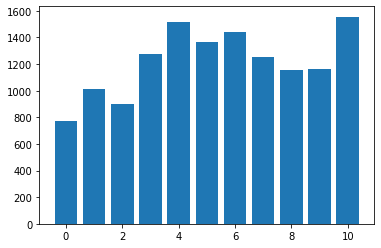

In [ ]:
plt.bar(np.arange(11), list(meta['integer'].value_counts().sort_index()))

We will randomly choose 5 instances for each one of our classes.

In [ ]:
instances = {}
for l in labels:
    label_path = os.path.join(r'/content/gdrive/MyDrive/IRMAS/train', l)
    ins = random.sample(os.listdir(label_path), 5)
    instances[l] = ins

From those sampled instances, let's briefly inspect one audio file. It belongs to the class 'gel', meaning electric guitar.

In [ ]:
audio, sr = librosa.load(os.path.join(r'/content/gdrive/MyDrive/IRMAS/train', 'gel' , instances['gel'][0]), mono = True)
print(instances['gel'][0])
print(audio.shape)
audio = audio[0: int(0.5*sr)]

036__[gel][dru][jaz_blu]0785__1.wav
(66150,)


As pointed out by the file name, this particular segment belongs to jazz-blues song and contains drums. By actually listening to it though, we see that indeed there are drums and also piano playing, which is a target class.

In [ ]:
import os
path = os.path.join(r'/content/gdrive/MyDrive/IRMAS/train', 'gel' , instances['gel'][0])
IPython.display.Audio(path)

Below we plot the first 0.5 second of the recording. We actually plot the first guitar note, which gradually fades. This is indicated by the wavefrom and its expanding wavelength.

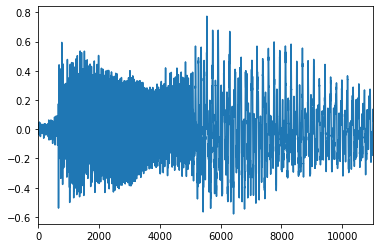

In [ ]:
plt.plot(np.arange(len(audio)), audio)
plt.xlim(0, int(0.5*sr))
plt.show()

The exact same pattern is revealed by the Mel-scaled spectrogram, but with much more frequency related information.

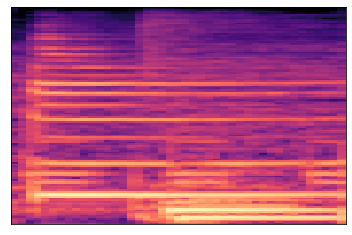

In [ ]:
 melspec = librosa.feature.melspectrogram(audio,
                                                 sr, 
                                                 n_fft = 1024,
                                                 hop_length = 259)
 librosa.display.specshow(librosa.power_to_db(melspec, ref = np.max))

Despite the good explainability of the representation of single audio instance through Mel-spectrograms, it is impossible to spot some discriminating pattern or characteristic when visualizing a small sample of instances. The next plot contains the Mel-spectrogram of 5 random samples from the 5 first classes.

In [ ]:
images = []
for l in labels[0:5]:
    for file in instances[l]:
        audio, sr = librosa.load(os.path.join(r'/content/gdrive/MyDrive/IRMAS/train', l ,file))
        audio = audio[0: int(1.5*sr)]
        melspec = librosa.feature.melspectrogram(audio,
                                                 sr, 
                                                 n_fft = 1024,
                                                 hop_length = 259)
        im = librosa.display.specshow(librosa.power_to_db(melspec, ref = np.max))
        im = np.reshape(im.get_array(), (128, 128))
        im = np.flip(im, axis = 0) 
        images.append(im)

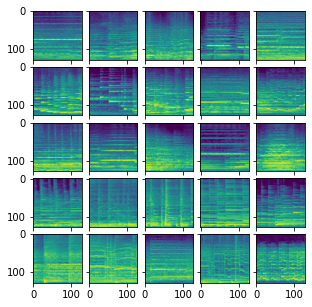

In [ ]:
fig = plt.figure(figsize=(5., 5.))

grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 5),  
                 axes_pad=0.1,  
                 )

for ax, img in zip(grid, images):
    ax.imshow(img)
plt.show()

# Classification
Due to resource limitations, the training of both models were done locally. On this notebook, we will only present the process of the training on this paragraph(train/validation loss and f1 score) and the evaluation of the models on the held out test dataset on the next one.


1. Custom CNN training:

Below we can see the train/validation loss and macro f1 score along with the early stopping checkpoint that stopped the gradient update and saved the model. The final achieved validation score of the model was *59%*.

| 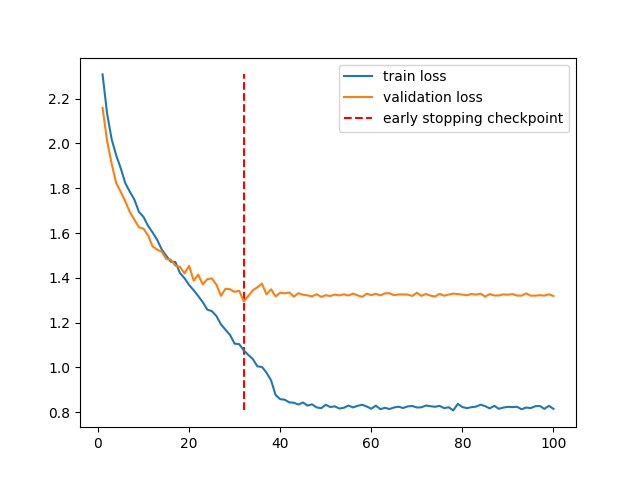 | 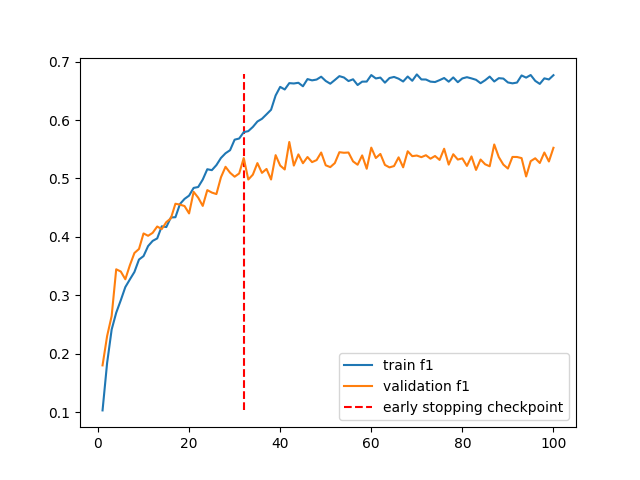 |
| :----------------------: | :--------------------------------: |
| Training/Validation loss | Training/Validation macro f1 score |

For this particular setup, data augmentation using frequency and time masking led to higher scores on both training and validation datasets, but also to overfit earlier on the training process.

2. Pretrained model training:

| 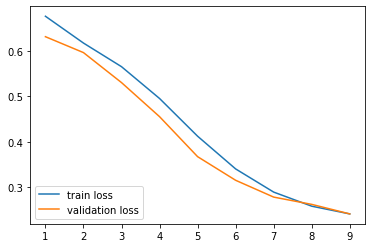 | 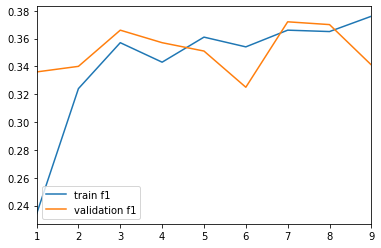 |
| :--------------------------: | :------------------------------: |
| Transfer learning loss curve | Transfer learning macro f1 score |

The pretrained VGG16 model converged without overfitting at epoch 17(Above only the last 9 epochs are displayed). 

# Evaluation

In [ ]:
from network_Gray_VGG import GrayVGG16_FC_BN
from MelSpecDataset import MelSpecDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/IRMAS/scripts')

1. Custom CNN training:

2. Pretrained CNN training:

We define the VGG16 model and the custom final dense layers. Then we load the trained state dictionary and evaluate the model on the test dataset. The order of the integer labels correspond to the order of the classes as listed in the dataset's description section above. For example, class 0 is cello.

In [ ]:
TL = GrayVGG16_FC_BN()
TL.classifier = nn.Sequential(nn.Linear(in_features = 8192, out_features = 4096),
                              nn.LeakyReLU(),
                              nn.BatchNorm1d(4096),
                              nn.Dropout(0.4),
                              nn.Linear(in_features = 4096, out_features = 512),
                              nn.LeakyReLU(),
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.2),
                              nn.Linear(in_features = 512, out_features = 11)).double()
TL.load_state_dict(torch.load(r'/content/gdrive/MyDrive/IRMAS/128x128_epoch18_0.48093387551390915.pt')['model_state_dict'])

<All keys matched successfully>

In [ ]:
df = pd.read_csv(r'/content/gdrive/MyDrive/IRMAS/128x128.csv')

train_df, test_df = train_test_split(df, test_size = 0.1, random_state = 13)
train_df, val_df = train_test_split(train_df, test_size = 0.15, random_state = 13)

test = MelSpecDataset(test_df, r'/content/gdrive/MyDrive/IRMAS/test_128x128')
testloader = DataLoader(test, shuffle = True, batch_size = 32)
print('Total test instances: {}'.format(len(test)))

Total test instances: 1341


In [ ]:
TL.eval()
TL.double()
y_true, y_pred = [], []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = TL(images)   
        for label in labels:
            y_true.append(label.data)
            
        for output in outputs:
            pred = torch.argmax(output)
            y_pred.append(pred.data)

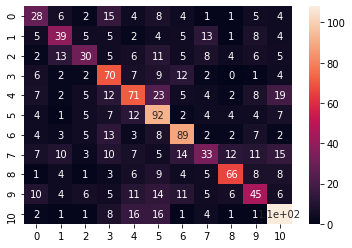

In [ ]:
conf = confusion_matrix(y_true, y_pred)
d = pd.DataFrame(conf, np.arange(11), np.arange(11))
sb.heatmap(d,annot=True)

In [ ]:
rep = classification_report(y_true, y_pred)
print(rep)

              precision    recall  f1-score   support

           0       0.37      0.36      0.36        78
           1       0.46      0.43      0.44        91
           2       0.46      0.32      0.37        95
           3       0.46      0.61      0.52       115
           4       0.49      0.45      0.47       158
           5       0.46      0.65      0.54       142
           6       0.59      0.64      0.61       138
           7       0.41      0.26      0.32       127
           8       0.67      0.57      0.62       115
           9       0.43      0.37      0.40       123
          10       0.59      0.68      0.63       159

    accuracy                           0.50      1341
   macro avg       0.49      0.48      0.48      1341
weighted avg       0.50      0.50      0.49      1341



From the classification report, it is obvious that the number of training instances greatly affect the performance and the generalization power of the model. For instance, cello(class 0) and human voice(class 10), the minority and majority classes as discussed above, show great deviation in their respective scores.

# Approaches that failed hard

During the tuning of the presented models we tested the influence of different methods as:
* Weight initialization methods as Kaiming uniform initialization with ReLU activation function, Xavier initialization with the tanh activation function.
* Data augmentation using stereo channel random swapping. The 2 channels of the 2D representations are randomly swaped with a probability of p =  only on the training data.
* Data augmentation by slicing training segments with overlap. While slicing the 3 second long train instances to 1.5 second resolution, we allowed a 67% overlap that obtains 4 instead of 2 segments from each instance. So, the slicing is performed using the [0, 1.5*sr], [0.5*sr, 2*sr], [sr, 2.5*sr], [1.5*sr, 3*sr] intervals.
* Convolution on both axis of the Mel-spectrogram in an attempt to extact both frequency and time domain information.
* Stacked Mel-spectrogram with its delta and delta-delta Mel-spectrograms in order to achieve a 3-channel image like representation as input for classic pretrained CNN models.
* Larger batch sizes led to losses with higher variance and more unstable results. Also, for deeper models we a large batch size caused memory related problems.

Apart from the presented models and feature representations we also tried the following approaches, none of which returned promising results:
* Custom CNNs with various inputs as Mel-scaled spectrogram, MFFCs, chromagram, tempogram, spectral features.
* RNN, LSTM with various inputs as Mel-scaled spectrogram, MFCCs, chromagram, spectral features. 
* CNN-LSTM combination with Mel-scaled spectrograms as imputs, the CNN model as feature extractor and the LSTM model as classifier.
* Autoendoder-LSTM combination with the same motivation as above.

Due to resource limitations deeper custom models or full unfrozen pretrained models could not be tested, although they have been shown to be good performers on our model[3].


# Conclusions

By heavily experimenting with the IRMAS dataset, we can safely conclude that:
* CNNs with Mel-scaled spectrograms seem to outperform other ANN architectures for the task of musical instrument classification.
* Mel-scaled spectrograms outperformed other features when using CNNs.
* A dataset suitable for a state of the art model should be large enough, represent a large variety of music genres and musical instruments. Those characteristics ensure that the trained model will be able to generalize well and avoid overfitting the train data.
* Deep models outperformed shallower models but were also hard to train.
* Frequency and time masking as a data augmentation method may cause a large quantity of information to be seen by the model more than once on each training epoch and, therefore, negatively impact overfitting. In our case, with the use of early stopping we benefited by this kind of augmentation.

# References

1. Bosch, J. J., Janer, J., Fuhrmann, F., & Herrera, P. “A Comparison of Sound Segregation Techniques for Predominant Instrument Recognition in Musical Audio Signals”, in Proc. ISMIR (pp. 559-564), 2012
2.Zhao, Yuzhi and Po, Lai-Man and Cheung, Kwok-Wai and Yu, Wing-Yin and Abbas Ur Rehman, Yasar, "SCGAN: Saliency Map-guided Colorization with Generative Adversarial Network", in IEEE Transactions on Circuits and Systems for Video Technology, 2020
3. Y. Han, J. Kim and K. Lee, "Deep Convolutional Neural Networks for Predominant Instrument Recognition in Polyphonic Music," in IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 25, no. 1, pp. 208-221, Jan. 2017, doi: 10.1109/TASLP.2016.2632307.